In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [3]:
df_train.describe()

,image,species,individual_id
count,51033,51033,51033
unique,51033,30,15587
top,00021adfb725ed.jpg,bottlenose_dolphin,37c7aba965a5
freq,1,9664,400


In [4]:
df_train.drop(columns=df_train.columns[2], axis=1, inplace=True)

In [5]:
pd.DataFrame(df_train)

,image,species
0,00021adfb725ed.jpg,melon_headed_whale
1,000562241d384d.jpg,humpback_whale
2,0007c33415ce37.jpg,false_killer_whale
3,0007d9bca26a99.jpg,bottlenose_dolphin
4,00087baf5cef7a.jpg,humpback_whale
...,...,...
51028,fff639a7a78b3f.jpg,beluga
51029,fff8b32daff17e.jpg,cuviers_beaked_whale
51030,fff94675cc1aef.jpg,blue_whale
51031,fffbc5dd642d8c.jpg,beluga


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [7]:
train_encoded = label_encoder.fit_transform(df_train['species'])
df_train['Encoded_labels'] = train_encoded

In [8]:
df_train

,image,species,Encoded_labels
0,00021adfb725ed.jpg,melon_headed_whale,18
1,000562241d384d.jpg,humpback_whale,14
2,0007c33415ce37.jpg,false_killer_whale,9
3,0007d9bca26a99.jpg,bottlenose_dolphin,2
4,00087baf5cef7a.jpg,humpback_whale,14
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,0
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,7
51030,fff94675cc1aef.jpg,blue_whale,1
51031,fffbc5dd642d8c.jpg,beluga,0


In [23]:
df_train['path'] = ["C:/Users/tinar/Downloads/archive/train_images-128-128/train_images-128-128/" + img for img in df_train['image']]
df_train.head()

,image,species,Encoded_labels,path
0,00021adfb725ed.jpg,melon_headed_whale,18,C:/Users/tinar/Downloads/archive/train_images-...
1,000562241d384d.jpg,humpback_whale,14,C:/Users/tinar/Downloads/archive/train_images-...
2,0007c33415ce37.jpg,false_killer_whale,9,C:/Users/tinar/Downloads/archive/train_images-...
3,0007d9bca26a99.jpg,bottlenose_dolphin,2,C:/Users/tinar/Downloads/archive/train_images-...
4,00087baf5cef7a.jpg,humpback_whale,14,C:/Users/tinar/Downloads/archive/train_images-...


In [59]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224,224])
    image /= 255.0  # normalize to [0,1] range

    return image

In [60]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [61]:
import tensorflow as tf

In [62]:
import plotly.express as px

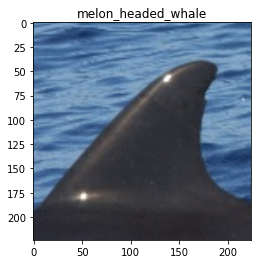

In [63]:
image_path = df_train['path'][0]
label =  df_train['species'][0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label)
print()

In [64]:
from tensorflow.keras.applications import MobileNetV2
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [65]:
path_ds = tf.data.Dataset.from_tensor_slices(df_train['path'])
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


In [66]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(df_train['Encoded_labels'], tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [67]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=1024)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [68]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable=True

prediction_layer = tf.keras.layers.Dense(len(df_train['Encoded_labels']))

In [69]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.25)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.25)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [70]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [72]:
model.fit(ds, epochs=10)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[32,144,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/mobilenetv2_1.00_224/block_2_depthwise_BN/FusedBatchNormV3
 (defined at C:\Users\tinar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py:605)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25056]

Errors may have originated from an input operation.
Input Source operations connected to node model_2/mobilenetv2_1.00_224/block_2_depthwise_BN/FusedBatchNormV3:
In[0] model_2/mobilenetv2_1.00_224/block_2_depthwise/depthwise (defined at C:\Users\tinar\anaconda3\lib\site-packages\keras\backend.py:5711)	
In[1] model_2/mobilenetv2_1.00_224/block_2_depthwise_BN/ReadVariableOp:	
In[2] model_2/mobilenetv2_1.00_224/block_2_depthwise_BN/ReadVariableOp_1:	
In[3] model_2/mobilenetv2_1.00_224/block_2_depthwise_BN/FusedBatchNormV3/ReadVariableOp:	
In[4] model_2/mobilenetv2_1.00_224/block_2_depthwise_BN/FusedBatchNormV3/ReadVariableOp_1:

Operation defined at: (most recent call last)
>>>   File "C:\Users\tinar\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 667, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\tinar\AppData\Local\Temp/ipykernel_17396/2727221753.py", line 1, in <module>
>>>     model.fit(ds, epochs=10)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 767, in call
>>>     outputs = self._fused_batch_norm(inputs, training=training)
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 623, in _fused_batch_norm
>>>     output, mean, variance = control_flow_util.smart_cond(
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
>>>     return tf.__internal__.smart_cond.smart_cond(
>>> 
>>>   File "C:\Users\tinar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 605, in _fused_batch_norm_inference
>>>     return tf.compat.v1.nn.fused_batch_norm(
>>> 